# Week 2: decoding analyses

This week's tutorial is about how to implement decoding analyses in Python. We'll be looking at the implementation of concepts like K-fold cross-validation, feature-selection/extraction, model fitting/prediction, permutation testing, and feature visualization. To do so, we'll use the [`scikit-learn`](http://scikit-learn.org) machine learning package in Python (the de-facto and most-used ML package in Python). Additionally, we'll use some functionality from the [`skbold`](http://skbold.readthedocs.io/en/latest/) to simplify some of steps in implementing decoding pipelines. In this tutorial, we'll use the PIOP-dataset (**P**opulation **I**maging **O**f **P**sychology), a large-scale (>240 subjects) multimodal MRI-dataset, including structural (gray-matter [VBM](https://en.wikipedia.org/wiki/Voxel-based_morphometry) and white-matter [TBSS](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/TBSS)), resting-state (incl. [dual regression](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/DualRegression) data), and task-based functional data. Along with this set of MRI-scans, the PIOP-study also acquired a set of behavioral (psychometric) variables from various questionnaires and behavioral task (outside the scanner) of the same participants who were scanned. As such, this makes it an excellent data-set for decoding analyses in which you can use neural patterns (from any MRI modality; `X`) to predict a behavioral variable (`y`). This is, by the way, also one of the data-sets that you can use for your final project (more info on Blackboard/week_4).

For this tutorial, we'll focus on a specific decoding analysis in which *we try to predict intelligence (y) from brain patterns (X) associated with working memory processing*. Throughout the tutorial, we'll discuss all the steps necessary to answer this research question. (Mini-ToThink: is this a within- or between-subject analysis?)

In terms of skills, after this tutorial you are be able to:

* Load and appropriately transform dependent variables (`y`) corresponding to your patterns (`X`);
* Apply basic [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html) to your patterns;
* Implement [feature-selection](http://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) and extraction processes;
* Build fully cross-validated [pipelines](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) using scikit-learn;
* Run appropriate statistics (including permutation tests) on your model performance scores;
* Visualize features by "back-projecting" (inverted) features to brain-space;

In combination with the knowledge/skills you acquired from last week's tutorial, you'll be able to implement a complete decoding pipeline yourself at the end of this tutorial!

## 1. Data representation (yet again)
Before we'll start with the machine learning stuff, we have to load in our patterns again. Like last week, you are going to use a custom `Mvp` class for this again, which we'll extend throughout this tutorial. You may use your own class from last week (given that it contains correct implementations of the load, standardize and apply_mask methods), or use the one in the solutions-notebook from last week. In any case, copy the code for the Mvp-class below:

In [1]:
import numpy as np
import nibabel as nib

class Mvp():
    """ Custom class to load, organize, and process multivoxel MRI patterns. """
    
    def __init__(self, paths):
        
        self.paths = paths
        
    def load(self, voxel_dims=(91, 109, 91)):
        
        X = np.zeros((len(self.paths), np.prod(voxel_dims)))

        # Start your loop here!
        for i, path in enumerate(self.paths):
    
            X[i, :] = nib.load(path).get_data().ravel()
        
        self.X = X
    
    def standardize(self):
        self.X = (self.X - self.X.mean(axis=0)) / self.X.std(axis=0)
        
    def apply_mask(self, path_to_mask, threshold):
        
        mask = nib.load(path_to_mask).get_data()
        mask_bool = mask > threshold
        self.X = self.X[:, mask_bool.ravel()]

Now, given our research question, we're going to use the (between-subject!\*) patterns of the working-memory task again. More specifically, we are going to use the patterns from the "active-passive" contrast of each subject. Let's check this pattern for one subject in `fslview`.    

---------------
\* It's a between-subject analysis because intelligence is a factor that varies at the subject level!

<div class='alert alert-warning'>
**ToDo**: open a terminal and type:<br><br>

`fslview` <br><br>

Now, add a standard MNI152 (2mm) brain by: `File` > `Add standard` > `Open` (the right MNI-file is automatically highlighted). Then, add the t-stat file from the active-passive contrast (i.e. tstat3.nii.gz) for subject "pi0025", by `File` > `Add`, and then selecting
`/home/Public/FirstLevel_piop/pi0025/pi0025-20150610-0008-WIPpiopwm.feat/reg_standard/tstat3.nii.gz` (see the picture below to see a detailed instruction how to do this in fslview). Now, set Min to 0 and Max to 3. Then, add the same file (tstat3.nii.gz of subject pi0025) *again*, but now set Min to 0 and Max to -3 (again, see img below for detailed instructions).

</div>

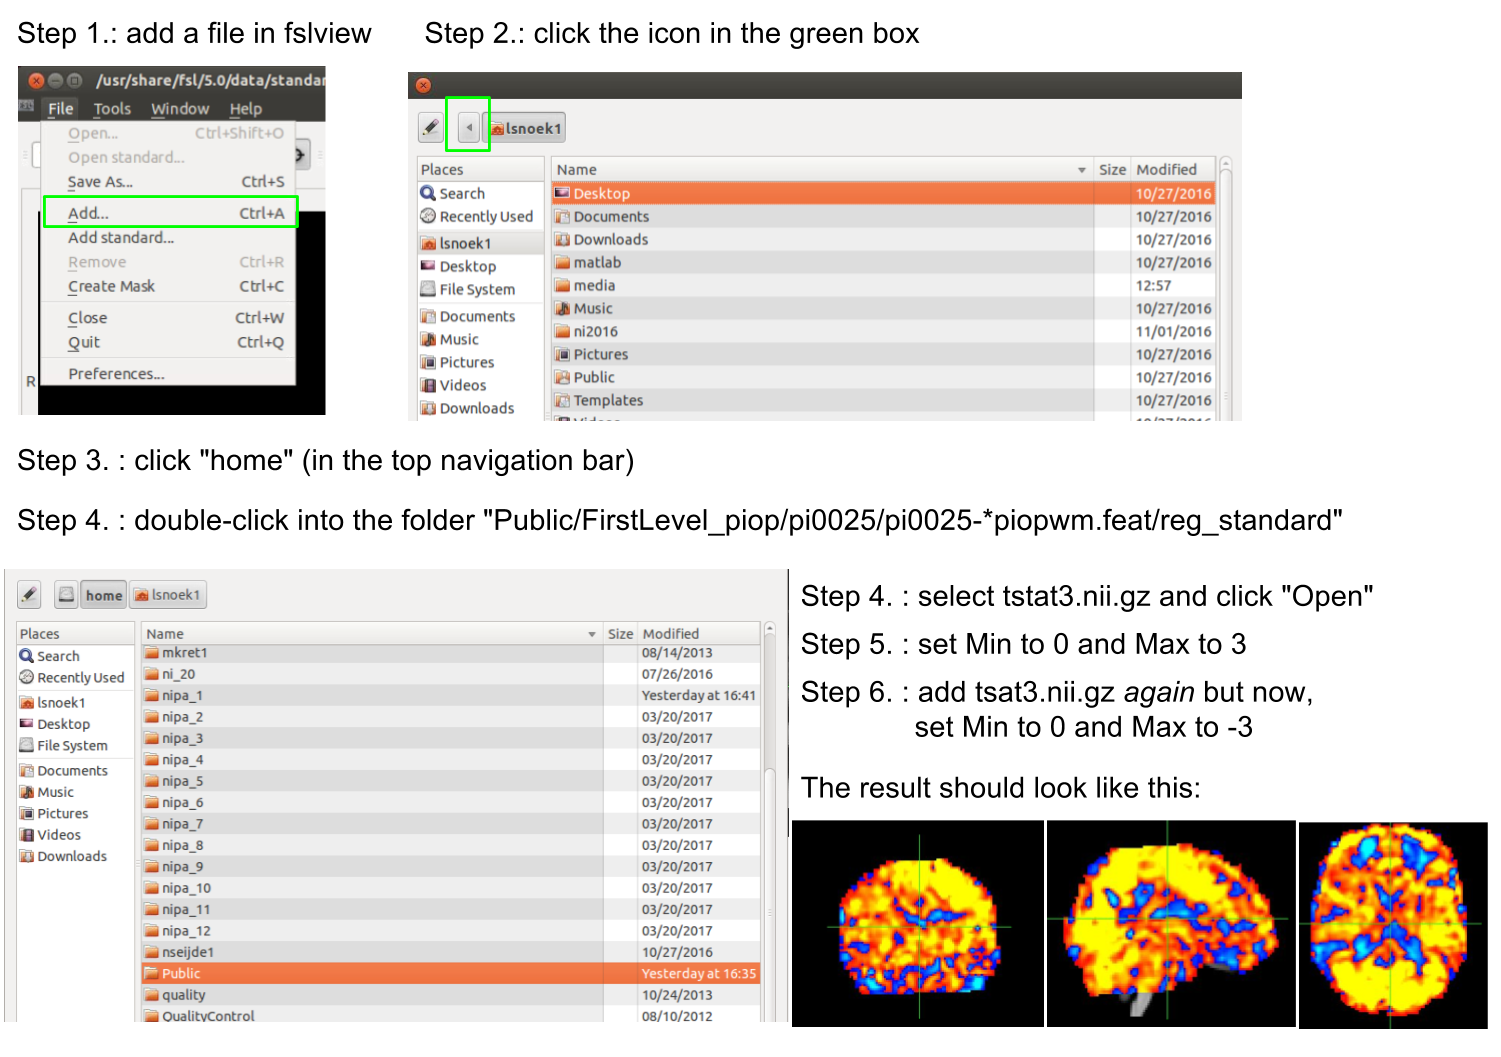

In [2]:
from IPython.display import Image
Image(filename='fslview.png')

<div class='alert alert-info'>
**ToThink**: think about what you are looking at now in fslview. What you just visualized is the brain pattern from one subject, or in ML lingo: the features from one sample. What do the "red/yellow" features represent here? And what do the "blue" features represent?
</div>

What we'd like to do now is to load in the tstat3 patterns from all subjects who completed the working-memory task in the scanner. To do so, use your 'glob' skills!

<div class='alert alert-warning'>
**ToDo**: use glob to find all the paths to the tstat3-files of the piopwm task. (Hint, you should find 217 paths in total)
</div>

In [7]:
# Implement the todo here (insert the right search-query in glob()):
from glob import glob
paths = glob('/home/lukas/between_data/pi*/*piopwm*/reg_standard/tstat3.nii.gz')
#paths = glob('/media/lukas/piop/PIOP/FirstLevel_piop/pi*/*piopwm*/reg_standard/tstat3.nii.gz')
print(len(paths))

29


Let's sort the paths, such that the paths are sorted by subject-number (pi0010 to pi0248). Also, let's not use *all* data (all subjects) at once, because that's actually quite memory-intensive and we don't want the TUX-server to crash. Therefore, we'll select only every third path (i.e. path 1, 4, 7, 10, etc.). 

In [8]:
paths = sorted(paths)
print("Number of paths was: %i" % len(paths))
subset_paths = paths[1::3]
print("Number of paths is now: %i" % len(subset_paths))

Number of paths was: 29
Number of paths is now: 10


Alright, now we have 72 paths (sorted by subject-number) to the subjects' tstat3 files. Let's initialize the Mvp object and call the `load()` method! 

<div class='alert alert-info'>
**ToThink**: before you initialize the Mvp object and load the patterns, can you predict what shape the `X`-attribute of the Mvp-object will be? (Hint: images in MNI152 2mm space are of shape 91\*109\*91)
</div>

Alright, less thinking, more doing:

In [10]:
mvp = Mvp(paths=subset_paths)
mvp.load()

Let's check the shape of the `X`-attribute:

In [11]:
print("Shape of X is: %s" % (mvp.X.shape,))

Shape of X is: (10, 902629)


Cool, we got the patterns (`X`) that we wanted. But as you might have noticed, we're still missing one crucial component for our decoding analysis: `y`! For our research question, we chose to focus on decoding intelligence, but how do we load and represent this in our pipeline? This is what the next section is about!


## 2. Adding a dependent variable (`y`)
While there is kind of a generic way to load in voxel patterns, there is usually not a single way to load in your dependent variable (y), because the exact factor that represents `y` dependent on your exact research question (and also depends how you have stored this data on disk). 

We'll focus on extracting a DV from a common tsv-file (like a csv-file, but not with comma- but tab-delimited values). Before we do that, just open the file and take a look at its structure. Just go to your desktop, double-click "Files", go up one directory (to `/home`) and go to `/home/Public/FirstLevel_piop`. Scroll aaaall the way down (past all the pi\* folders) and you'll find a file called `PIOP_BEHAV_NIPA.tsv` file. Double-click this, and press "Display". A "Text Import" window will pop up - select here "Tab" under the "Separated by" option. Then, click "OK". 

You'll see a spreadsheet with the subject-names in the first column and different variables in the columns. Basically, you can choose any variable in the columns as your to-be-decoded factor! For our example, we will pick the 'Raven' variable, which represents the subjects' (continuous) scores on the [Raven](https://en.wikipedia.org/wiki/Raven%27s_Progressive_Matrices) test, which aims to measure fluid intelligence. 

To load in the tsv-file, we'll use `pandas`, a Python package for working with tabular data. It's main data structure is called the `DataFrame`, which is very similar to the dataframe-object in R. (Working with pandas is beyond the scope of this course, but you'll see it now and then throughout the course when we work with tsv-files.)

In [26]:
import pandas as pd # This is how pandas usually is imported

#path_to_tsv = '/media/lukas/piop/PIOP/FirstLevel_piop/PIOP_BEHAV_NIPA.tsv'
path_to_tsv = '~/between_data/PIOP_BEHAV_NIPA.tsv'

# the read_csv function is the standard way to load in spreadsheet-like data
df = pd.read_csv(path_to_tsv, sep='\t', index_col=0)
y = df['Raven_raw']
print("Length of y is: %i\n" % y.shape[0])
print("y looks like:\n\n%r" % y)

Length of y is: 248

y looks like:

pi0001    21
pi0002    28
pi0003    24
pi0004    23
pi0005    24
pi0006    31
pi0007    25
pi0008    25
pi0009    23
pi0010    18
pi0011    26
pi0012    23
pi0013    20
pi0014    28
pi0015    23
pi0016    25
pi0017    28
pi0018    14
pi0019    25
pi0020    19
pi0021    32
pi0022    21
pi0023    19
pi0024    26
pi0025    27
pi0026    24
pi0027    14
pi0028    30
pi0029    26
pi0030    24
          ..
pi0219    17
pi0220    14
pi0221    20
pi0222    25
pi0223    21
pi0224    28
pi0225    20
pi0226    25
pi0227    30
pi0228    24
pi0229    14
pi0230    19
pi0231    20
pi0232    20
pi0233    26
pi0234    26
pi0235    23
pi0236    16
pi0237    32
pi0238    28
pi0239    20
pi0240    23
pi0241    23
pi0242    24
pi0243    25
pi0244    25
pi0245    23
pi0246    32
pi0247    24
pi0248    23
Name: Raven_raw, dtype: int64


As you can see, y consists of one column (with the Raven score) and a corresponding "index", which refers to the subject it belongs to. But we have a problem now. `y` now contains 248 values (from 248 subjects), but our X attribute contains patterns from only 70 subjects (the subset selected earlier). For our analysis, the samples in our patterns (X) should match the entries in our dependent variable (y). How do we do this? Well, we need to extract which subjects were included in X and then use those subjects to "index" y. 

Below, we show you a way to do this.

In [43]:
# Here we extract the subject-names from the paths
subject_names = [path.split('/')[4] for path in subset_paths]

# Here we use the pandas "loc" method, which slices the DataFrame by their
# index names
y_new = y.loc[subject_names].tolist()

# y_new is now a list, but we'd like it to be a numpy array
y_new = np.array(y_new)

# And we can see now that the length of y is the same as the number of samples in X
print(mvp.X.shape)
print(y_new.shape)

(10, 902629)
(10,)
